<a href="https://colab.research.google.com/github/KorvenDalas/MSc_FYP/blob/main/_FYP%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P1. Tweets ↔ Daily Tesla Stock

## Setup

In [29]:
!pip install vaderSentiment --quiet

In [30]:
# =========================================================
# Libraries
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import pearsonr
import statsmodels.api as sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats

# =========================================================
# Configuration
# =========================================================
DATA_URL = "https://raw.githubusercontent.com/KorvenDalas/MSc_FYP/refs/heads/main/Elon%20M%20Tweets.csv"

# Stock ticker to analyse
TICKER = "TSLA"

# Cut-off date: restricts analysis to relevant period
CUTOFF = "2018-01-01"

# US market closing time in UTC (14:30–21:00 UTC)
MKT_CLOSE_HOUR = 21

# Maximum lag for correlation analysis (e.g. t+1, t+2, …, t+MAX_LAG)
MAX_LAG = 3

# Set plotting style
sns.set(style="whitegrid")

## Load Tweets

In [31]:
# =========================================================
# Load and Prepare Tweet Data
# =========================================================

# Load Elon Musk tweets from GitHub repository
tweets = pd.read_csv(DATA_URL)

# Parse 'Datetime' column to proper datetime format (force errors to NaT)
tweets['Datetime'] = pd.to_datetime(tweets['Datetime'], errors='coerce')

# Drop rows where 'Datetime' parsing failed
tweets = tweets.dropna(subset=['Datetime']).copy()

# Sanity check: ensure the dataset contains the expected 'Text' column
assert 'Text' in tweets.columns, "Expected 'Text' column not found in dataset."

# Preview first three rows
tweets.head(3)

,Datetime,Tweet Id,Text,Username
0,2023-06-29 16:20:19+00:00,1674452749378002945,@mwseibel Yup,elonmusk
1,2023-06-29 15:53:52+00:00,1674446089179766789,@TitterDaily True,elonmusk
2,2023-06-29 03:46:37+00:00,1674263071337111552,@paulg Generational trauma. An example of why ...,elonmusk


In [32]:
# =========================================================
# Inspect Timezone Information
# =========================================================

# Check the timezone of the 'Datetime' column
print("Timezone information:", tweets['Datetime'].dt.tz)

# Preview the first few timestamps
print("Sample timestamps:")
print(tweets['Datetime'].head())

Timezone information: UTC
Sample timestamps:
0   2023-06-29 16:20:19+00:00
1   2023-06-29 15:53:52+00:00
2   2023-06-29 03:46:37+00:00
3   2023-06-29 01:19:59+00:00
4   2023-06-28 18:05:58+00:00
Name: Datetime, dtype: datetime64[ns, UTC]


## Sentiment & Tweet Features

In [33]:
# =========================================================
# Sentiment Analysis and Metadata Extraction
# =========================================================

# Initialise VADER sentiment analyser
analyzer = SentimentIntensityAnalyzer()

# Ensure text column is string type
tweets['Text'] = tweets['Text'].astype(str)

# Compute VADER compound sentiment scores (-1 to +1)
tweets['Compound'] = tweets['Text'].apply(lambda t: analyzer.polarity_scores(t)['compound'])

# Assign sentiment labels based on VADER thresholds
tweets['Sentiment_label'] = tweets['Compound'].apply(
    lambda c: 'Positive' if c > 0.05 else ('Negative' if c < -0.05 else 'Neutral')
)

# Extract additional metadata
tweets['Is_reply']   = tweets['Text'].str.strip().str.startswith('@')  # identifies reply tweets
tweets['Word_count'] = tweets['Text'].apply(lambda x: len(str(x).split()))  # counts words per tweet

# =========================================================
# Sanity Checks
# =========================================================
print("Total tweets loaded:", len(tweets))
print("Date range:", tweets['Datetime'].min().date(), "→", tweets['Datetime'].max().date())
print("\nSample of processed tweets:")
print(tweets[['Text', 'Datetime', 'Compound', 'Sentiment_label', 'Is_reply', 'Word_count']].head(3))

Total tweets loaded: 24450
Date range: 2010-06-04 → 2023-06-29

Sample of processed tweets:
                                                Text  \
0                                      @mwseibel Yup   
1                                  @TitterDaily True   
2  @paulg Generational trauma. An example of why ...   

                   Datetime  Compound Sentiment_label  Is_reply  Word_count  
0 2023-06-29 16:20:19+00:00    0.0000         Neutral      True           2  
1 2023-06-29 15:53:52+00:00    0.4215        Positive      True           2  
2 2023-06-29 03:46:37+00:00   -0.7787        Negative      True          21  


## EDA — All Tweets

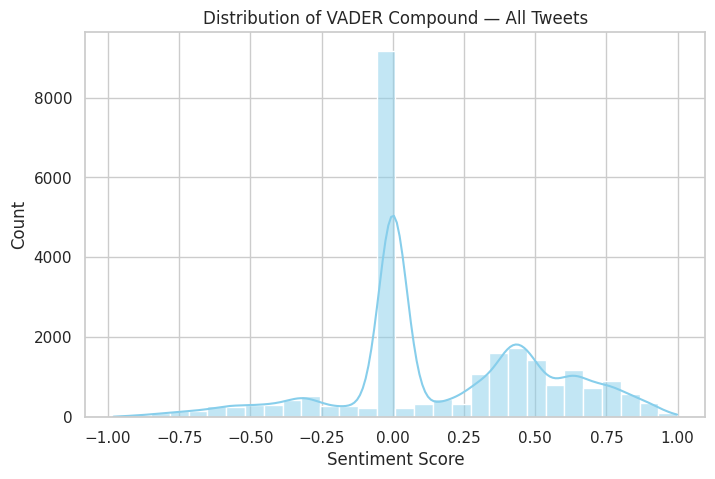

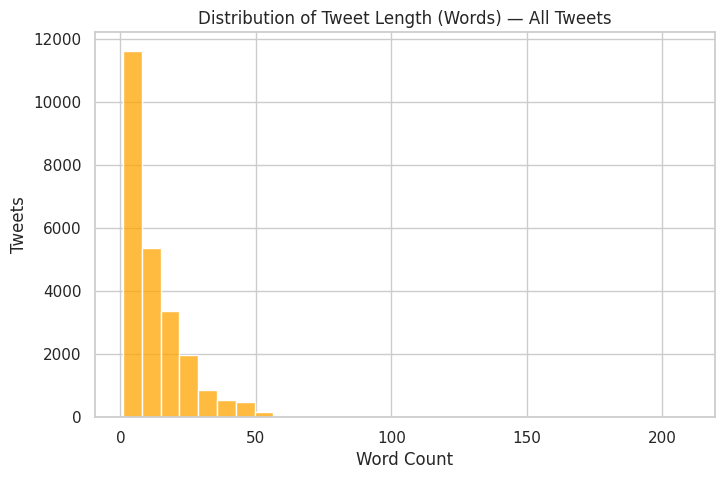

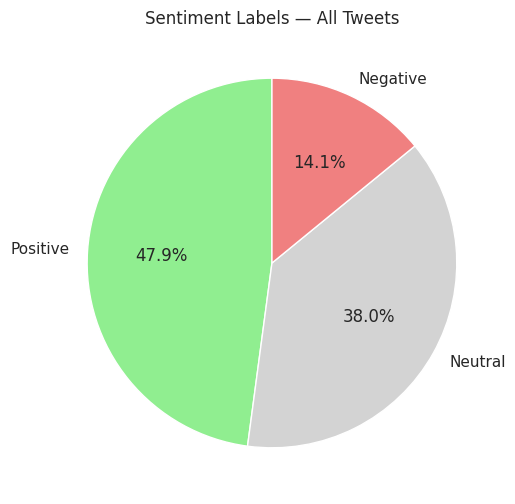

/tmp/ipython-input-2141461090.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=tweets['Is_reply'].map({False: 'Original', True: 'Reply'}), palette="pastel")


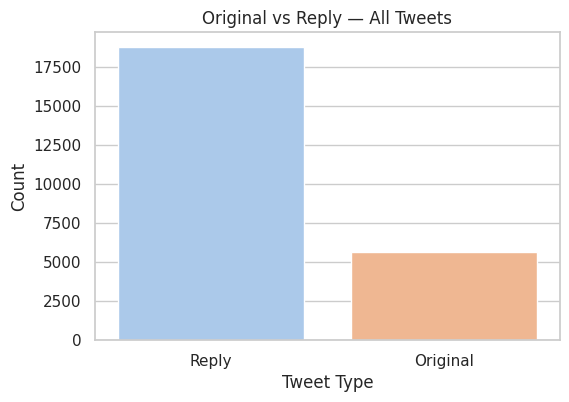

/tmp/ipython-input-2141461090.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tweets.set_index('Datetime').resample('M').size().plot(color="steelblue")


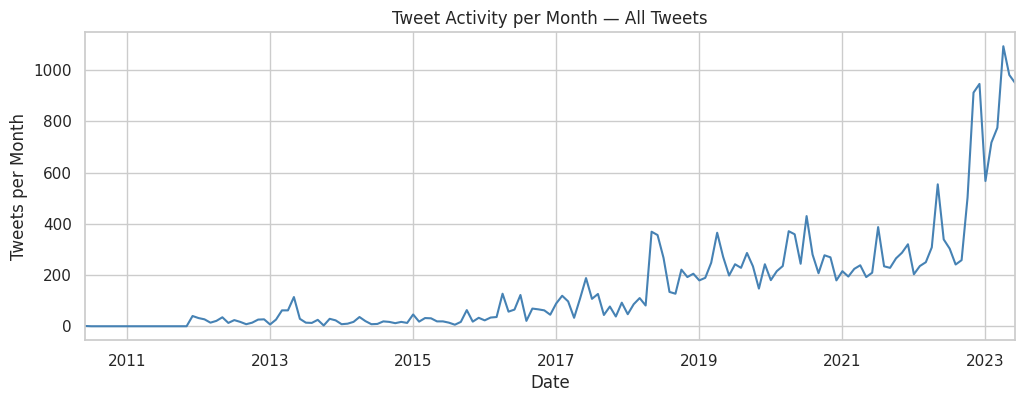

/tmp/ipython-input-2141461090.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tweets.set_index('Datetime').resample('M')['Compound'].mean().plot(color="green")


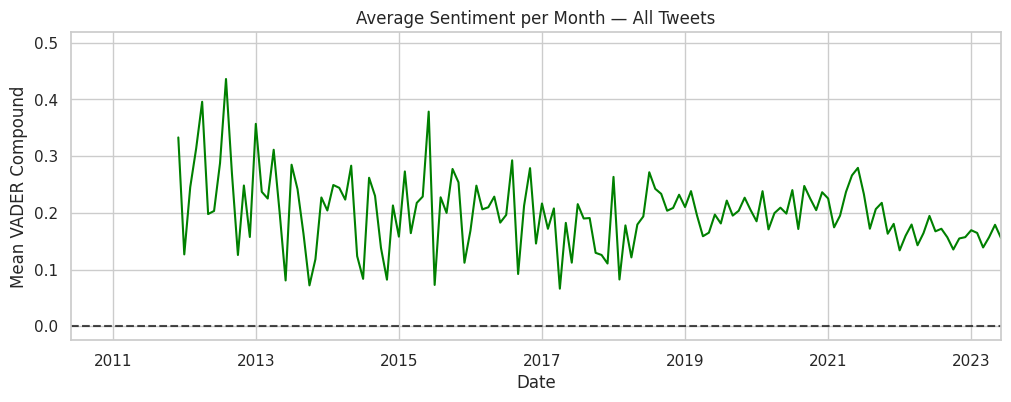

In [34]:
# =========================================================
# Exploratory Data Analysis (EDA) — Tweet Sentiment & Metadata
# =========================================================

figsize = (8, 5)

# --- Distribution of sentiment scores ---
plt.figure(figsize=figsize)
sns.histplot(tweets['Compound'], bins=30, kde=True, color="skyblue")
plt.title("Distribution of VADER Compound — All Tweets")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

# --- Distribution of tweet lengths ---
plt.figure(figsize=figsize)
sns.histplot(tweets['Word_count'], bins=30, color="orange")
plt.title("Distribution of Tweet Length (Words) — All Tweets")
plt.xlabel("Word Count")
plt.ylabel("Tweets")
plt.show()

# --- Sentiment label proportions ---
plt.figure(figsize=(6, 6))
tweets['Sentiment_label'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, colors=["lightgreen", "lightgrey", "lightcoral"]
)
plt.ylabel("")
plt.title("Sentiment Labels — All Tweets")
plt.show()

# --- Original vs reply tweets ---
plt.figure(figsize=(6, 4))
sns.countplot(x=tweets['Is_reply'].map({False: 'Original', True: 'Reply'}), palette="pastel")
plt.title("Original vs Reply — All Tweets")
plt.xlabel("Tweet Type")
plt.ylabel("Count")
plt.show()

# --- Monthly tweet activity ---
plt.figure(figsize=(12, 4))
tweets.set_index('Datetime').resample('M').size().plot(color="steelblue")
plt.title("Tweet Activity per Month — All Tweets")
plt.xlabel("Date")
plt.ylabel("Tweets per Month")
plt.show()

# --- Monthly average sentiment ---
plt.figure(figsize=(12, 4))
tweets.set_index('Datetime').resample('M')['Compound'].mean().plot(color="green")
plt.title("Average Sentiment per Month — All Tweets")
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Mean VADER Compound")
plt.show()

## Focus Period (≥ 2018-01-01)

/tmp/ipython-input-3557114818.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tweets_per_month = tweets.resample('M', on='Datetime').size()
/tmp/ipython-input-3557114818.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tweets_filtered_per_month = tweets_filtered.resample('M', on='Datetime').size()


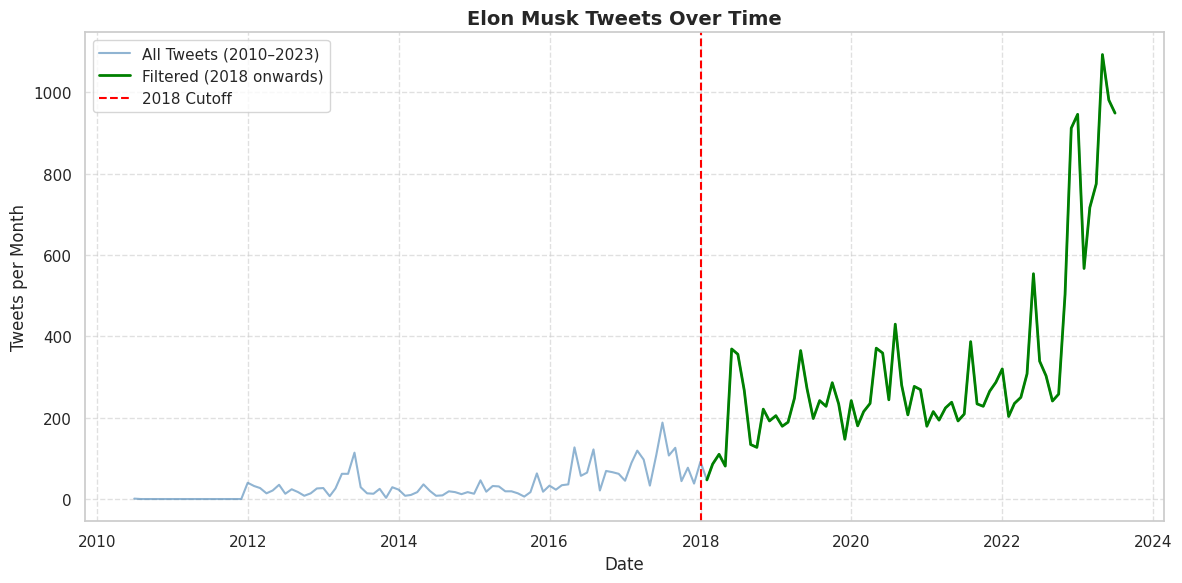

In [35]:
# =========================================================
# Tweet Activity Over Time — Before and After 2018 Cutoff
# =========================================================

# Ensure datetime is properly parsed (UTC already enforced earlier)
tweets['Datetime'] = pd.to_datetime(tweets['Datetime'])

# --- Count tweets per month (full sample) ---
tweets_per_month = tweets.resample('M', on='Datetime').size()

# --- Count tweets per month (filtered: 2018 onwards) ---
tweets_filtered = tweets[tweets['Datetime'] >= '2018-01-01'].copy()
tweets_filtered_per_month = tweets_filtered.resample('M', on='Datetime').size()

# --- Plot tweet activity ---
plt.figure(figsize=(12, 6))
plt.plot(
    tweets_per_month.index, tweets_per_month.values,
    label="All Tweets (2010–2023)", color="steelblue", alpha=0.6
)
plt.plot(
    tweets_filtered_per_month.index, tweets_filtered_per_month.values,
    label="Filtered (2018 onwards)", color="green", linewidth=2
)
plt.axvline(
    pd.to_datetime("2018-01-01"), color="red", linestyle="--",
    label="2018 Cutoff"
)

# --- Labels and formatting ---
plt.title("Elon Musk Tweets Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Tweets per Month")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [36]:
# =========================================================
# 3. Get Tesla Trading Days (Daily Frequency)
# =========================================================

# Define start and end dates based on tweet dataset
start_date = tweets['Datetime'].min().strftime('%Y-%m-%d')
end_date   = tweets['Datetime'].max().strftime('%Y-%m-%d')

# --- Download Tesla daily OHLCV data from Yahoo Finance ---
tsla = yf.download(
    tickers="TSLA",
    start=start_date,
    end=end_date,
    interval="1d"
)

# Reset index so 'Date' becomes a column
tsla.reset_index(inplace=True)

# Quick check
print("Tesla data loaded:", tsla.shape[0], "rows")
print("Date range:", tsla['Date'].min().date(), "→", tsla['Date'].max().date())

/tmp/ipython-input-1321854556.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla = yf.download(
[*********************100%***********************]  1 of 1 completed

Tesla data loaded: 3272 rows
Date range: 2010-06-29 → 2023-06-28


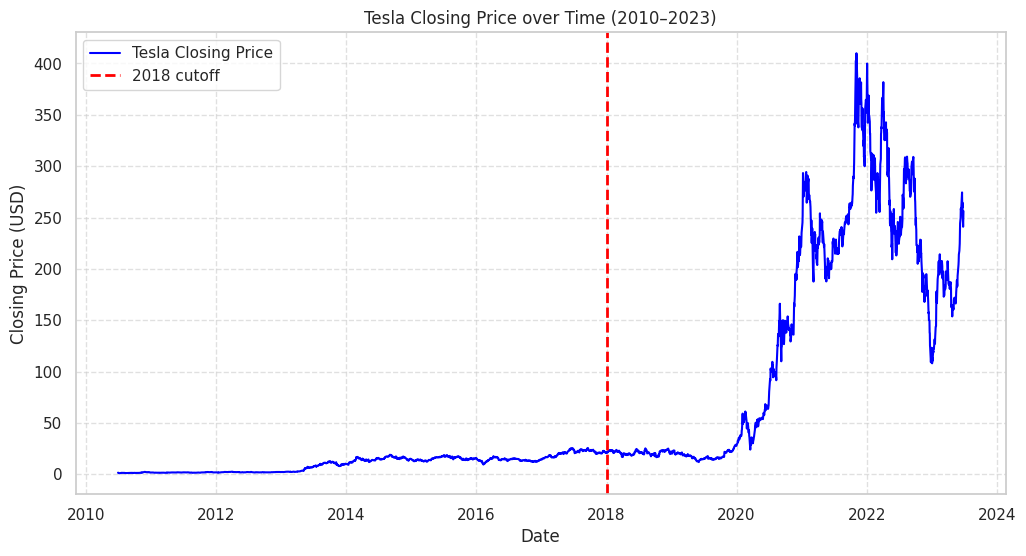

In [37]:
# =========================================================
# Plot Tesla Closing Price Over Time
# =========================================================

plt.figure(figsize=(12, 6))

# Plot daily closing prices
plt.plot(tsla['Date'], tsla['Close'], label="Tesla Closing Price", color="blue")

# Add vertical cutoff line for 2018
plt.axvline(
    pd.to_datetime("2018-01-01"),
    color="red",
    linestyle="--",
    linewidth=2,
    label="2018 cutoff"
)

# Formatting
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.title("Tesla Closing Price over Time (2010–2023)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()

In [38]:
# =========================================================
# 4) Apply Focus Period Filter (≥ 2018-01-01)
# =========================================================

# Filter tweets to focus period (2018 onwards)
tweets_f = tweets[tweets['Datetime'] >= CUTOFF].copy()

# Track counts before and after filtering
n_before  = len(tweets)
n_after   = len(tweets_f)
n_removed = n_before - n_after

# Print summary statistics
print("Tweets before filtering:", n_before)
print(f"Tweets removed: {n_removed} ({n_removed / n_before:.2%})")
print("Focused tweets:", n_after)
print("Focused date range:",
      tweets_f['Datetime'].min().date(), "→", tweets_f['Datetime'].max().date())

Tweets before filtering: 24450
Tweets removed: 3053 (12.49%)
Focused tweets: 21397
Focused date range: 2018-01-03 → 2023-06-29


## Market Data

/tmp/ipython-input-987153573.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla = yf.download(TICKER, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed


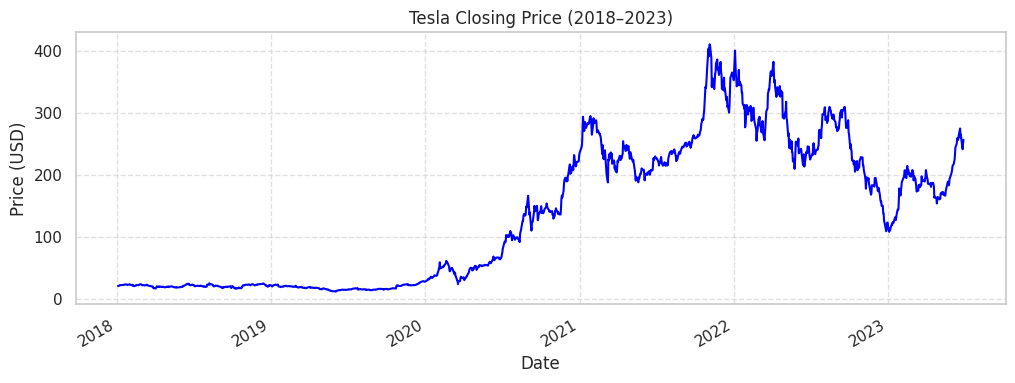

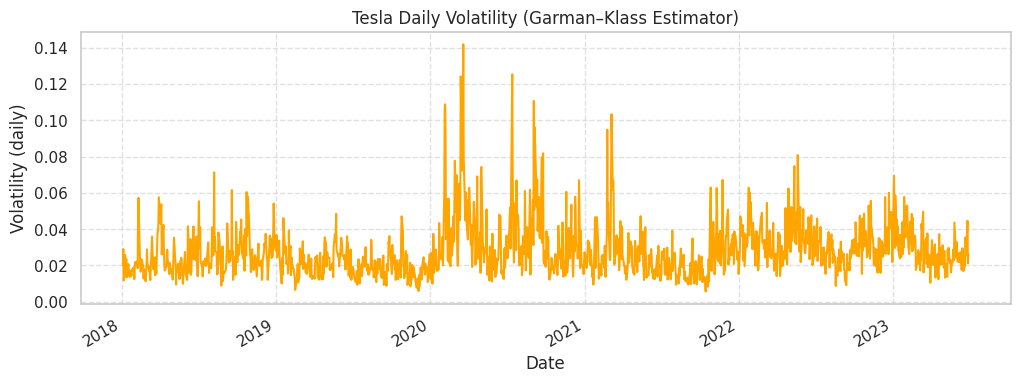

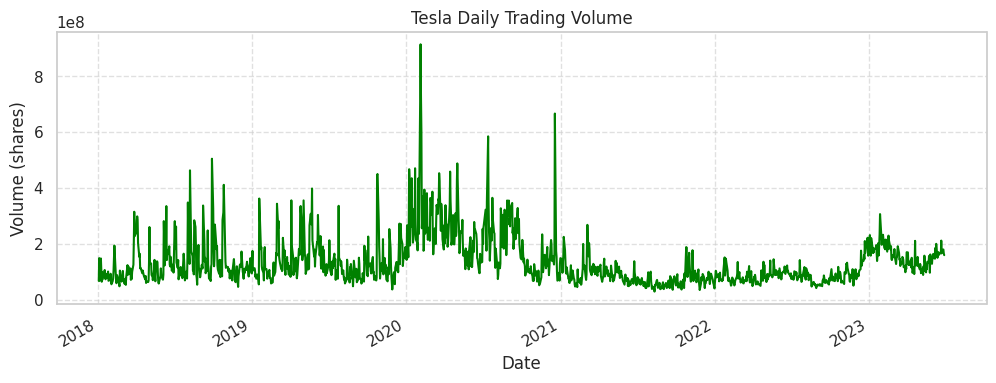

Observations loaded: 1380
        Date      Close       High        Low    Open     Volume  \
0 2018-01-03  21.150000  21.683332  21.036667  21.400   67822500   
1 2018-01-04  20.974667  21.236668  20.378668  20.858  149194500   
2 2018-01-05  21.105333  21.149332  20.799999  21.108   68868000   

   DailyVolatility  
0         0.020125  
1         0.028955  
2         0.011777  


In [39]:
# =========================================================
# 5) Tesla Daily Stock Data (2018–2023)
# =========================================================

# Define start and end dates based on filtered tweet dataset
start = tweets_f['Datetime'].min().strftime('%Y-%m-%d')
end   = tweets_f['Datetime'].max().strftime('%Y-%m-%d')

# Download Tesla daily stock data via yfinance
# Note: yfinance returns [start, end), so the last day is exclusive
tsla = yf.download(TICKER, start=start, end=end, interval="1d")

# Flatten MultiIndex columns (sometimes returned by yfinance)
if isinstance(tsla.columns, pd.MultiIndex):
    tsla.columns = [c[0] if isinstance(c, tuple) else c for c in tsla.columns]

# Reset index to keep 'Date' as a column
tsla = tsla.reset_index()

# ---------------------------------------------------------
# Plot Tesla daily closing price
plt.figure(figsize=(12,4))
tsla.set_index('Date')['Close'].plot(color='blue')
plt.title("Tesla Closing Price (2018–2023)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ---------------------------------------------------------
# Compute daily volatility using the Garman–Klass estimator
tsla['DailyVolatility'] = (
    0.5 * (np.log(tsla['High'] / tsla['Low']))**2
    - (2 * np.log(2) - 1) * (np.log(tsla['Close'] / tsla['Open']))**2
)
tsla['DailyVolatility'] = np.sqrt(tsla['DailyVolatility'].clip(lower=0))

# Plot daily volatility
plt.figure(figsize=(12,4))
tsla.set_index('Date')['DailyVolatility'].plot(color='orange')
plt.title("Tesla Daily Volatility (Garman–Klass Estimator)")
plt.xlabel("Date")
plt.ylabel("Volatility (daily)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ---------------------------------------------------------
# Plot daily trading volume
plt.figure(figsize=(12,4))
tsla.set_index('Date')['Volume'].plot(color='green')
plt.title("Tesla Daily Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume (shares)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ---------------------------------------------------------
# Quick sanity check
print("Observations loaded:", len(tsla))
print(tsla.head(3))

## Dataset Variants

In [40]:
# =========================================================
# 6) Dataset Variants
# =========================================================
# Different filtered versions of the tweet dataset are created to
# test robustness and reduce noise from non-informative tweets.
# - all:                full dataset (2018–2023)
# - no_replies:         excludes replies (keeps original tweets only)
# - no_short:           excludes tweets with < 3 words
# - no_replies_no_short: excludes both replies and short tweets
# =========================================================

variants = {
    "all": tweets_f.copy(),
    "no_replies": tweets_f[~tweets_f["Is_reply"]].copy(),
    "no_short": tweets_f[tweets_f["Word_count"] >= 3].copy(),
}

# Apply combined filter (no replies AND no short tweets)
variants["no_replies_no_short"] = variants["no_replies"][variants["no_replies"]["Word_count"] >= 3].copy()

# Quick summary of dataset sizes
variant_sizes = {name: len(df) for name, df in variants.items()}
print("Dataset sizes after filtering:")
for name, size in variant_sizes.items():
    print(f"  {name}: {size} tweets")

Dataset sizes after filtering:
  all: 21397 tweets
  no_replies: 4102 tweets
  no_short: 17755 tweets
  no_replies_no_short: 3476 tweets


## Map Tweets to Trading Days

In [41]:
# =========================================================
# Check datetime parsing
# =========================================================
# Ensure timestamps carry timezone information (should be UTC).
# Printing the timezone of the datetime column and inspecting
# the first few entries for sanity checking.
# =========================================================

print("Timezone info:", tweets["Datetime"].dt.tz)
print("First 5 timestamps:\n", tweets["Datetime"].head())

Timezone info: UTC
First 5 timestamps:
 0   2023-06-29 16:20:19+00:00
1   2023-06-29 15:53:52+00:00
2   2023-06-29 03:46:37+00:00
3   2023-06-29 01:19:59+00:00
4   2023-06-28 18:05:58+00:00
Name: Datetime, dtype: datetime64[ns, UTC]


In [42]:
# =========================================================
# Functions for aligning tweets to trading days and
# aggregating daily sentiment
# =========================================================

def map_to_trading_day(df, market_close_hour_utc=MKT_CLOSE_HOUR):
    """
    Map tweet timestamps to the appropriate trading date.
    - Tweets posted after market close (≥ market_close_hour_utc)
      are assigned to the next trading day.
    - Weekends are skipped (mapped forward to Monday).

    Parameters:
        df : DataFrame with a 'Datetime' column
        market_close_hour_utc : int, hour of market close in UTC

    Returns:
        DataFrame with a new 'Trading_Date' column
    """
    mapped = []
    for dt in df['Datetime']:
        if dt.hour >= market_close_hour_utc:
            # Assign to next weekday
            nxt = dt + pd.Timedelta(days=1)
            while nxt.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
                nxt += pd.Timedelta(days=1)
            mapped.append(nxt.date())
        else:
            mapped.append(dt.date())

    out = df.copy()
    out['Trading_Date'] = pd.to_datetime(mapped)
    return out


def aggregate_daily(df):
    """
    Aggregate tweet-level data into daily sentiment metrics.

    Parameters:
        df : DataFrame with 'Compound' and 'Sentiment_label'

    Returns:
        DataFrame grouped by Trading_Date with:
        - avg_sentiment : mean compound score
        - tweet_count   : total number of tweets
        - pos_count     : number of positive tweets
        - neg_count     : number of negative tweets
    """
    g = (
        df.groupby('Trading_Date')
          .agg(
              avg_sentiment=('Compound', 'mean'),
              tweet_count=('Compound', 'count'),
              pos_count=('Sentiment_label', lambda x: (x == 'Positive').sum()),
              neg_count=('Sentiment_label', lambda x: (x == 'Negative').sum())
          )
          .reset_index()
          .rename(columns={'Trading_Date': 'Date'})
    )
    return g


# =========================================================
# Build daily sentiment tables and merge with TSLA market data
# =========================================================

daily_tables = {}
merged_tables = {}

for name, df in variants.items():
    # Aggregate tweets → daily level
    daily = aggregate_daily(map_to_trading_day(df))
    daily['Date'] = pd.to_datetime(daily['Date'])

    # Merge with stock data
    m = tsla.copy()
    m['Date'] = pd.to_datetime(m['Date'])
    merged = pd.merge(m, daily, on='Date', how='left')

    # Compute daily returns
    merged['Return'] = merged['Close'].pct_change()

    # Store results
    daily_tables[name] = daily
    merged_tables[name] = merged

print("Datasets prepared:", list(daily_tables.keys()))


Datasets prepared: ['all', 'no_replies', 'no_short', 'no_replies_no_short']


## Correlations with p-values

In [43]:
# =========================================================
# Function: Correlation with significance (Pearson's r + p-value)
# =========================================================

def corr_with_p(x, y):
    """
    Compute Pearson correlation coefficient and p-value
    between two pandas Series.

    Handles missing values gracefully by applying a mask.
    Returns NaN if fewer than 3 valid observations exist.

    Parameters:
        x, y : pandas Series

    Returns:
        r : float, correlation coefficient
        p : float, p-value
        n : int, number of valid observations
    """
    mask = x.notna() & y.notna()
    if mask.sum() < 3:
        return np.nan, np.nan, int(mask.sum())

    r, p = pearsonr(x[mask], y[mask])
    return float(r), float(p), int(mask.sum())


# =========================================================
# Correlation analysis: Returns vs. daily tweet aggregates
# =========================================================

rows = []
for name, df in merged_tables.items():
    # Compute correlations for each variable of interest
    r_s, p_s, n = corr_with_p(df['Return'], df['avg_sentiment'])
    r_c, p_c, _ = corr_with_p(df['Return'], df['tweet_count'])
    r_p, p_p, _ = corr_with_p(df['Return'], df['pos_count'])
    r_n, p_n, _ = corr_with_p(df['Return'], df['neg_count'])

    rows.append({
        'Dataset': name,
        'N': n,
        'r(Return, Sentiment)': r_s, 'p_sentiment': p_s,
        'r(Return, Count)': r_c,     'p_count': p_c,
        'r(Return, PosCount)': r_p,  'p_pos': p_p,
        'r(Return, NegCount)': r_n,  'p_neg': p_n,
    })

# Build results table
corr_table = pd.DataFrame(rows).sort_values('Dataset')

# Preview
print("Correlation analysis complete. Table preview:")

corr_table

Correlation analysis complete. Table preview:


,Dataset,N,"r(Return, Sentiment)",p_sentiment,"r(Return, Count)",p_count,"r(Return, PosCount)",p_pos,"r(Return, NegCount)",p_neg
0,all,1289,0.026171,0.347798,0.009123,0.743495,0.026466,0.342389,-0.021264,0.445586
1,no_replies,937,0.104930,0.001297,0.021555,0.509885,0.069042,0.034593,-0.057253,0.079837
3,no_replies_no_short,898,0.119898,0.000317,0.017400,0.602560,0.074475,0.025631,-0.073424,0.027794
2,no_short,1278,0.042982,0.124597,0.014199,0.612056,0.038558,0.168338,-0.024467,0.382155


## Lagged Correlations

In [44]:
# =========================================================
# Lagged Correlation Analysis: Sentiment vs. Future Returns
# =========================================================

lag_rows = []

for name, df in merged_tables.items():
    base = df.copy()

    # For each lag (t+1 ... t+MAX_LAG)
    for lag in range(1, MAX_LAG + 1):
        # Shift returns forward by 'lag' days
        base[f'Return_t+{lag}'] = base['Return'].shift(-lag)

        # Compute correlation between today's sentiment and future returns
        r, p, n = corr_with_p(base['avg_sentiment'], base[f'Return_t+{lag}'])

        # Store results
        lag_rows.append({
            'Dataset': name,
            'Lag': lag,
            'r(Sent, Return t+lag)': r,
            'p_value': p,
            'N': n
        })

# Build results table
lag_table = pd.DataFrame(lag_rows).sort_values(['Dataset', 'Lag'])

# Preview results
print("Lagged correlation analysis complete. Table preview:")

lag_table

Lagged correlation analysis complete. Table preview:


,Dataset,Lag,"r(Sent, Return t+lag)",p_value,N
0,all,1,0.048188,0.083735,1289
1,all,2,-0.048980,0.078885,1288
2,all,3,-0.007375,0.791521,1287
3,no_replies,1,0.036077,0.269936,937
4,no_replies,2,-0.043545,0.183170,936
5,no_replies,3,0.005071,0.876937,935
9,no_replies_no_short,1,0.017380,0.602977,898
10,no_replies_no_short,2,-0.060095,0.072024,897
11,no_replies_no_short,3,0.006936,0.835758,896
6,no_short,1,0.055048,0.049129,1278


##  OLS Regressions

In [45]:
# =========================================================
# OLS Regressions (Baseline Model)
# Return_t ~ α + β1 * avg_sentiment_t + β2 * tweet_count_t
# Robust HC3 standard errors
# =========================================================

ols_rows = []

for name, df in merged_tables.items():
    # Drop rows with missing key variables
    d = df.dropna(subset=['Return', 'avg_sentiment', 'tweet_count']).copy()

    # Skip if not enough observations
    if len(d) < 5:
        ols_rows.append({'Dataset': name, 'N': len(d)})
        continue

    # Define regressors (X) and dependent variable (y)
    X = sm.add_constant(d[['avg_sentiment', 'tweet_count']])  # add constant α
    y = d['Return']

    # Estimate OLS model with HC3 robust standard errors
    model = sm.OLS(y, X).fit(cov_type='HC3')

    # Collect results
    ols_rows.append({
        'Dataset': name,
        'N': len(d),
        'coef_const': model.params.get('const', np.nan),
        'p_const':    model.pvalues.get('const', np.nan),
        'coef_sent':  model.params.get('avg_sentiment', np.nan),
        'p_sent':     model.pvalues.get('avg_sentiment', np.nan),
        'coef_count': model.params.get('tweet_count', np.nan),
        'p_count':    model.pvalues.get('tweet_count', np.nan),
        'R2':         model.rsquared
    })

# Build results table
ols_table = pd.DataFrame(ols_rows).sort_values('Dataset')

# Preview results
print("OLS regression (baseline) complete. Table preview:")

ols_table

OLS regression (baseline) complete. Table preview:


,Dataset,N,coef_const,p_const,coef_sent,p_sent,coef_count,p_count,R2
0,all,1289,0.000928,0.660939,0.006359,0.295511,0.000039,0.676765,0.000801
1,no_replies,937,-0.001994,0.414550,0.017191,0.000309,0.000534,0.346643,0.011941
3,no_replies_no_short,898,-0.002321,0.368003,0.018329,0.000061,0.000538,0.430025,0.015105
2,no_short,1278,-0.000036,0.986820,0.009853,0.100979,0.000078,0.532444,0.002137


/tmp/ipython-input-3911552570.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order, y=vals, palette="Blues_d")


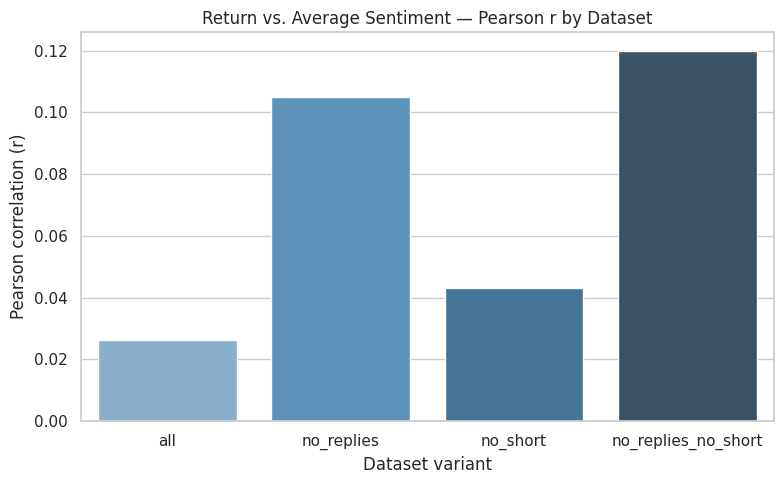

In [46]:
# =========================================================
# Correlation Plot: Return vs. Average Sentiment
# Displays Pearson correlation coefficients across datasets
# =========================================================

# Define dataset order for plotting
order = ['all', 'no_replies', 'no_short', 'no_replies_no_short']

# Extract r(Return, Sentiment) values in the desired order
vals = [
    corr_table.loc[corr_table['Dataset'] == k, 'r(Return, Sentiment)'].values[0]
    for k in order
]

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=order, y=vals, palette="Blues_d")

# Titles and labels
plt.title("Return vs. Average Sentiment — Pearson r by Dataset")
plt.xlabel("Dataset variant")
plt.ylabel("Pearson correlation (r)")

# Show plot
plt.tight_layout()
plt.show()

## OLS Extended (+Volatility +Volume)

In [47]:
# ============================================================
# OLS Regressions: Baseline vs Extended
# Baseline: Return ~ Sentiment + Tweet Count
# Extended: + Daily Volatility + log(Volume+1)
# Robust HC3 standard errors applied
# ============================================================

# Ensure log-transformed volume exists
for name, df in merged_tables.items():
    merged_tables[name] = df.assign(log_volume=np.log1p(df['Volume']))

# Define model columns
cols_baseline = ['avg_sentiment', 'tweet_count']
cols_controls = ['DailyVolatility', 'log_volume']

# Storage for results
rows_baseline, rows_extended = [], []

for name, df in merged_tables.items():
    # Drop missing rows
    d = df.dropna(subset=['Return'] + cols_baseline + cols_controls).copy()

    if len(d) < 10:
        # Skip small datasets (insufficient observations)
        rows_baseline.append({'Dataset': name, 'N': len(d)})
        rows_extended.append({'Dataset': name, 'N': len(d)})
        continue

    # -------------------------
    # Baseline model
    # -------------------------
    Xb = sm.add_constant(d[cols_baseline])
    y  = d['Return']
    mb = sm.OLS(y, Xb).fit(cov_type='HC3')  # robust SEs

    rows_baseline.append({
        'Dataset': name, 'N': len(d),
        'coef_const': mb.params.get('const', np.nan),
        'se_const':   mb.bse.get('const', np.nan),
        'p_const':    mb.pvalues.get('const', np.nan),
        'coef_sent':  mb.params.get('avg_sentiment', np.nan),
        'se_sent':    mb.bse.get('avg_sentiment', np.nan),
        'p_sent':     mb.pvalues.get('avg_sentiment', np.nan),
        'coef_count': mb.params.get('tweet_count', np.nan),
        'se_count':   mb.bse.get('tweet_count', np.nan),
        'p_count':    mb.pvalues.get('tweet_count', np.nan),
        'R2':         mb.rsquared
    })

    # -------------------------
    # Extended model
    # -------------------------
    Xe = sm.add_constant(d[cols_baseline + cols_controls])
    me = sm.OLS(y, Xe).fit(cov_type='HC3')

    rows_extended.append({
        'Dataset': name, 'N': len(d),
        'coef_const':  me.params.get('const', np.nan),
        'se_const':    me.bse.get('const', np.nan),
        'p_const':     me.pvalues.get('const', np.nan),
        'coef_sent':   me.params.get('avg_sentiment', np.nan),
        'se_sent':     me.bse.get('avg_sentiment', np.nan),
        'p_sent':      me.pvalues.get('avg_sentiment', np.nan),
        'coef_count':  me.params.get('tweet_count', np.nan),
        'se_count':    me.bse.get('tweet_count', np.nan),
        'p_count':     me.pvalues.get('tweet_count', np.nan),
        'coef_vol':    me.params.get('DailyVolatility', np.nan),
        'se_vol':      me.bse.get('DailyVolatility', np.nan),
        'p_vol':       me.pvalues.get('DailyVolatility', np.nan),
        'coef_logvol': me.params.get('log_volume', np.nan),
        'se_logvol':   me.bse.get('log_volume', np.nan),
        'p_logvol':    me.pvalues.get('log_volume', np.nan),
        'R2':          me.rsquared,
        'Adj_R2':      me.rsquared_adj
    })

# Create result tables
baseline_table = pd.DataFrame(rows_baseline).sort_values('Dataset')
extended_table = pd.DataFrame(rows_extended).sort_values('Dataset')

# Display results
print("=== Baseline (Return ~ Sentiment + Count), robust SEs ===")
display(baseline_table)

print("\n=== Extended (+ DailyVolatility + log(Volume+1)), robust SEs ===")
display(extended_table)

# R² comparison: extended vs baseline
r2_compare = (
    extended_table[['Dataset', 'R2']]
    .merge(baseline_table[['Dataset', 'R2']], on='Dataset', suffixes=('_extended', '_baseline'))
)

print("\n=== R² comparison (extended vs baseline) ===")
display(r2_compare)

=== Baseline (Return ~ Sentiment + Count), robust SEs ===


,Dataset,N,coef_const,se_const,p_const,coef_sent,se_sent,p_sent,coef_count,se_count,p_count,R2
0,all,1289,0.000928,0.002115,0.660939,0.006359,0.006079,0.295511,0.000039,0.000093,0.676765,0.000801
1,no_replies,937,-0.001994,0.002444,0.414550,0.017191,0.004765,0.000309,0.000534,0.000567,0.346643,0.011941
3,no_replies_no_short,898,-0.002321,0.002578,0.368003,0.018329,0.004570,0.000061,0.000538,0.000682,0.430025,0.015105
2,no_short,1278,-0.000036,0.002181,0.986820,0.009853,0.006007,0.100979,0.000078,0.000125,0.532444,0.002137



=== Extended (+ DailyVolatility + log(Volume+1)), robust SEs ===


,Dataset,N,coef_const,se_const,p_const,coef_sent,se_sent,p_sent,coef_count,se_count,p_count,coef_vol,se_vol,p_vol,coef_logvol,se_logvol,p_logvol,R2,Adj_R2
0,all,1289,-0.248272,0.057105,0.000014,0.005779,0.005979,0.333831,0.000012,0.000095,0.895808,-0.381936,0.172562,0.026875,0.014025,0.003201,0.000012,0.024039,0.020998
1,no_replies,937,-0.244491,0.068557,0.000362,0.017321,0.004671,0.000209,0.000653,0.000566,0.248588,-0.464613,0.158780,0.003432,0.013747,0.003789,0.000285,0.036378,0.032242
3,no_replies_no_short,898,-0.245748,0.070673,0.000507,0.018664,0.004506,0.000034,0.000667,0.000685,0.330438,-0.466011,0.165969,0.004988,0.013792,0.003906,0.000414,0.039545,0.035242
2,no_short,1278,-0.244733,0.057496,0.000021,0.009465,0.005891,0.108123,0.000041,0.000126,0.748074,-0.363872,0.173169,0.035618,0.013757,0.003225,0.000020,0.024196,0.021130



=== R² comparison (extended vs baseline) ===


,Dataset,R2_extended,R2_baseline
0,all,0.024039,0.000801
1,no_replies,0.036378,0.011941
2,no_replies_no_short,0.039545,0.015105
3,no_short,0.024196,0.002137


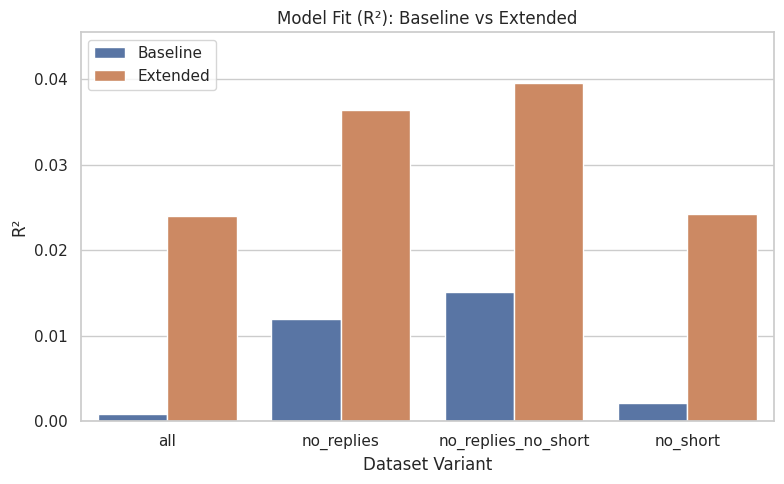

In [48]:
# ============================================================
# 11A) R² Comparison — Baseline vs Extended Models
# ============================================================

# Ensure baseline_table and extended_table exist
if 'baseline_table' in globals() and 'extended_table' in globals():
    # Merge R² values from both models
    r2_compare = (
        extended_table[['Dataset', 'R2']]
        .merge(baseline_table[['Dataset', 'R2']], on='Dataset',
               suffixes=('_extended', '_baseline'))
    )
else:
    raise RuntimeError(
        "Run the OLS Baseline/Extended regression cell first "
        "to create baseline_table and extended_table."
    )

# Convert to long format for seaborn plotting
r2_long = (
    pd.melt(r2_compare,
            id_vars='Dataset',
            value_vars=['R2_baseline', 'R2_extended'],
            var_name='Model',
            value_name='R²')
    .replace({'R2_baseline': 'Baseline', 'R2_extended': 'Extended'})
)

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=r2_long, x='Dataset', y='R²', hue='Model')

plt.title("Model Fit (R²): Baseline vs Extended")
plt.xlabel("Dataset Variant")
plt.ylabel("R²")
plt.legend(title="", loc="upper left")

# Set y-axis to show some headroom above the highest bar
plt.ylim(0, r2_long['R²'].max() * 1.15)

plt.tight_layout()
plt.show()

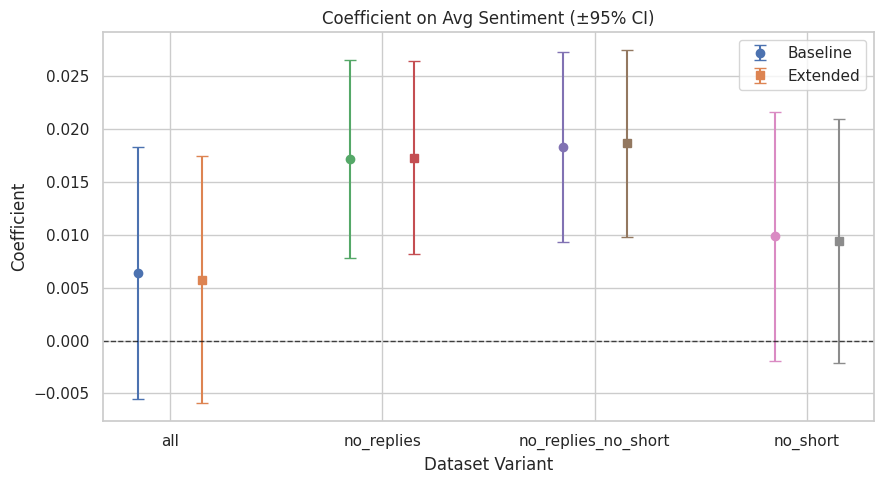

,Dataset,Model,coef,CI_95%,p
0,all,Baseline,0.006359,"[-0.0056, 0.0183]",0.295511
4,all,Extended,0.005779,"[-0.0059, 0.0175]",0.333831
1,no_replies,Baseline,0.017191,"[0.0079, 0.0265]",0.000309
5,no_replies,Extended,0.017321,"[0.0082, 0.0265]",0.000209
2,no_replies_no_short,Baseline,0.018329,"[0.0094, 0.0273]",0.000061
6,no_replies_no_short,Extended,0.018664,"[0.0098, 0.0275]",0.000034
3,no_short,Baseline,0.009853,"[-0.0019, 0.0216]",0.100979
7,no_short,Extended,0.009465,"[-0.0021, 0.0210]",0.108123


In [49]:
# ============================================================
# Sentiment Coefficient ±95% CI — Baseline vs Extended
# Using HC3 Robust Standard Errors
# ============================================================

def ci95(coef, se):
    """Return the 95% confidence interval given coefficient and SE."""
    return coef - 1.96 * se, coef + 1.96 * se


# --- Build long dataframe of coefficients + CI for sentiment ---
rows = []

# Baseline model
for _, row in baseline_table.iterrows():
    if pd.notna(row.get("coef_sent")) and pd.notna(row.get("se_sent")):
        lo, hi = ci95(row["coef_sent"], row["se_sent"])
        rows.append({
            "Dataset": row["Dataset"],
            "Model": "Baseline",
            "coef": row["coef_sent"],
            "lo": lo,
            "hi": hi,
            "p": row.get("p_sent", np.nan)
        })

# Extended model
for _, row in extended_table.iterrows():
    if pd.notna(row.get("coef_sent")) and pd.notna(row.get("se_sent")):
        lo, hi = ci95(row["coef_sent"], row["se_sent"])
        rows.append({
            "Dataset": row["Dataset"],
            "Model": "Extended",
            "coef": row["coef_sent"],
            "lo": lo,
            "hi": hi,
            "p": row.get("p_sent", np.nan)
        })

coef_long = pd.DataFrame(rows)

# --- Plot ---
plt.figure(figsize=(9, 5))

# Manual plotting of Baseline vs Extended per dataset
for i, (ds, sub) in enumerate(coef_long.groupby("Dataset", sort=False)):
    # Offset baseline and extended for side-by-side display
    x_base = i - 0.15
    x_ext  = i + 0.15

    b = sub[sub["Model"] == "Baseline"]
    e = sub[sub["Model"] == "Extended"]

    # Baseline coefficient + CI
    if len(b):
        plt.errorbar(
            x_base, b["coef"].values[0],
            yerr=[[b["coef"].values[0] - b["lo"].values[0]],
                  [b["hi"].values[0] - b["coef"].values[0]]],
            fmt="o", capsize=4, label="Baseline" if i == 0 else None
        )

    # Extended coefficient + CI
    if len(e):
        plt.errorbar(
            x_ext, e["coef"].values[0],
            yerr=[[e["coef"].values[0] - e["lo"].values[0]],
                  [e["hi"].values[0] - e["coef"].values[0]]],
            fmt="s", capsize=4, label="Extended" if i == 0 else None
        )

# Reference line at 0
plt.axhline(0, linestyle="--", linewidth=1, color="black", alpha=0.7)

# Axis labels and formatting
plt.xticks(range(len(coef_long["Dataset"].unique())),
           coef_long["Dataset"].unique())
plt.title("Coefficient on Avg Sentiment (±95% CI)")
plt.xlabel("Dataset Variant")
plt.ylabel("Coefficient")
plt.legend()
plt.tight_layout()
plt.show()

# --- Table for Appendix ---
coef_table = coef_long.copy()
coef_table["CI_95%"] = coef_table.apply(
    lambda r: f"[{r['lo']:.4f}, {r['hi']:.4f}]",
    axis=1
)
coef_table_out = coef_table[
    ["Dataset", "Model", "coef", "CI_95%", "p"]
].sort_values(["Dataset", "Model"])

display(coef_table_out)

# P2. High-Frequency Event

## Setup (excluding short tweets and replies)

In [50]:
# ============================================================
# High-Frequency Data Preparation
# ============================================================

# --- Select dataset variant ---
# Options: 'all', 'no_replies', 'no_short', 'no_replies_no_short'
DATASET_CHOICE = 'no_replies_no_short'

tweets_intraday = variants[DATASET_CHOICE].copy()
tweets_intraday = tweets_intraday[['Datetime', 'Compound', 'Sentiment_label']]

# --- Load High-Frequency Tesla Stock Data (15m & 60m) ---
url_15m = (
    "https://github.com/KorvenDalas/MSc_FYP/raw/refs/heads/main/"
    "Tesla%20Stock%202018-2023%20-%2015min.xlsx"
)
url_60m = (
    "https://github.com/KorvenDalas/MSc_FYP/raw/refs/heads/main/"
    "Tesla%20Stock%202018-2023%20-%2060min.xlsx"
)

# Read Excel files directly from GitHub
tsla_15m = pd.read_excel(url_15m)
tsla_60m = pd.read_excel(url_60m)

# Quick check
tsla_15m.head()

,Date,Open,High,Low,Close,Volume
0,2018-01-02 14:30:00,20.8000,21.0833,20.7333,21.0472,5442090
1,2018-01-02 14:45:00,21.0413,21.1807,21.0333,21.1553,4660755
2,2018-01-02 15:00:00,21.1547,21.2267,21.1480,21.1900,4298865
3,2018-01-02 15:15:00,21.1927,21.2580,21.1433,21.1569,2563545
4,2018-01-02 15:30:00,21.1613,21.1853,21.0933,21.1252,1872510


In [51]:
# ============================================================
# Preprocess Intraday Tesla Stock Data (15m & 60m)
# ============================================================

# --- Standardize column names ---
# Ensure both datasets use 'Datetime' for the time index
tsla_15m = tsla_15m.rename(columns={'Date': 'Datetime'})
tsla_60m = tsla_60m.rename(columns={'Date': 'Datetime'})

# --- Ensure datetime parsing (UTC timezone) ---
tsla_15m['Datetime'] = pd.to_datetime(tsla_15m['Datetime'], utc=True)
tsla_60m['Datetime'] = pd.to_datetime(tsla_60m['Datetime'], utc=True)

# --- Sort chronologically ---
tsla_15m = tsla_15m.sort_values('Datetime').reset_index(drop=True)
tsla_60m = tsla_60m.sort_values('Datetime').reset_index(drop=True)

# --- Compute returns and clean volume ---
for df in [tsla_15m, tsla_60m]:
    # Simple percentage returns
    df['Return'] = df['Close'].pct_change()

    # Log returns (alternative measure, useful in finance)
    df['logReturn'] = np.log(df['Close']).diff()

    # Replace missing volume with zero
    df['Volume'] = df['Volume'].fillna(0)

In [52]:
# ============================================================
# Align Tweets with Intraday Trading Bars (15m & 60m)
# ============================================================

# --- Ensure consistent timezone (UTC) and sorting ---
tweets_intraday['Datetime'] = pd.to_datetime(tweets_intraday['Datetime'], utc=True)
tsla_15m['Datetime']        = pd.to_datetime(tsla_15m['Datetime'], utc=True)
tsla_60m['Datetime']        = pd.to_datetime(tsla_60m['Datetime'], utc=True)

tweets_intraday = tweets_intraday.sort_values('Datetime').reset_index(drop=True)
tsla_15m        = tsla_15m.sort_values('Datetime').reset_index(drop=True)
tsla_60m        = tsla_60m.sort_values('Datetime').reset_index(drop=True)


def align_tweets_to_bars_asof(tweets: pd.DataFrame, bars: pd.DataFrame) -> pd.DataFrame:
    """
    Align tweets with the first trading bar at or after the tweet time.

    Parameters
    ----------
    tweets : pd.DataFrame
        DataFrame containing at least:
        - 'Datetime': UTC timestamp of tweet
        - 'Compound': VADER sentiment score
        - 'Sentiment_label': categorical sentiment ('Positive','Neutral','Negative')
    bars : pd.DataFrame
        Intraday stock data with:
        - 'Datetime': UTC timestamp of bar open/close
        (must be sorted chronologically)

    Returns
    -------
    aligned : pd.DataFrame
        Each tweet mapped to the first trading bar at/after posting time.
        Columns:
        - 'TweetTime' : timestamp of tweet
        - 'BarTime'   : matched bar timestamp
        - 'Compound'  : sentiment score
        - 'Sentiment' : sentiment label
    """
    # Prepare tweet-side (left) and bar-side (right) keys
    left = (tweets
            .rename(columns={'Datetime': 'TweetTime', 'Sentiment_label': 'Sentiment'})
            [['TweetTime', 'Compound', 'Sentiment']])

    right = bars.rename(columns={'Datetime': 'BarTime'})[['BarTime']]

    # Perform as-of merge (forward means first bar >= tweet time)
    aligned = pd.merge_asof(
        left.sort_values('TweetTime'),
        right.sort_values('BarTime'),
        left_on='TweetTime',
        right_on='BarTime',
        direction='forward',
        allow_exact_matches=True
    )

    # Drop tweets that occur after the last available bar
    aligned = aligned.dropna(subset=['BarTime']).copy()

    return aligned[['TweetTime', 'BarTime', 'Compound', 'Sentiment']]


# --- Align tweets with 15m and 60m bars ---
aligned_15m = align_tweets_to_bars_asof(tweets_intraday, tsla_15m)
aligned_60m = align_tweets_to_bars_asof(tweets_intraday, tsla_60m)

print("Aligned tweets (15m):", len(aligned_15m))
print("Aligned tweets (60m):", len(aligned_60m))

aligned_15m

Aligned tweets (15m): 3476
Aligned tweets (60m): 3476


,TweetTime,BarTime,Compound,Sentiment
0,2018-01-03 05:38:16+00:00,2018-01-03 14:30:00+00:00,0.8685,Positive
1,2018-01-03 08:22:31+00:00,2018-01-03 14:30:00+00:00,0.4588,Positive
2,2018-01-05 00:30:00+00:00,2018-01-05 14:30:00+00:00,0.0000,Neutral
3,2018-01-08 17:17:45+00:00,2018-01-08 17:30:00+00:00,0.3818,Positive
4,2018-01-24 18:35:00+00:00,2018-01-24 18:45:00+00:00,0.1280,Positive
...,...,...,...,...
3471,2023-06-27 05:32:23+00:00,2023-06-27 14:30:00+00:00,0.0000,Neutral
3472,2023-06-27 23:12:47+00:00,2023-06-28 14:30:00+00:00,0.6588,Positive
3473,2023-06-27 23:14:26+00:00,2023-06-28 14:30:00+00:00,0.0000,Neutral
3474,2023-06-28 17:04:07+00:00,2023-06-28 17:15:00+00:00,0.7096,Positive


In [53]:
def build_event_windows_from_aligned(bars: pd.DataFrame,
                                     aligned: pd.DataFrame,
                                     window=(-4, 12)) -> pd.DataFrame:
    """
    Construct event windows of returns and volumes around aligned tweets.

    Parameters
    ----------
    bars : pd.DataFrame
        Intraday OHLCV data. Must contain:
        - 'Datetime': bar timestamp
        - 'Return':   bar-to-bar return
        - 'Volume':   trading volume
    aligned : pd.DataFrame
        Output of `align_tweets_to_bars_asof`. Must contain:
        - 'TweetTime': timestamp of tweet
        - 'BarTime':   aligned bar timestamp
        - 'Sentiment': sentiment label
        - 'Compound':  sentiment score
    window : tuple of int, default=(-4, 12)
        Range of lags around the event bar to include.
        Example: (-4,12) means 4 bars before to 12 bars after.

    Returns
    -------
    events : pd.DataFrame
        Event-study style dataset with:
        - 'TweetTime': timestamp of tweet
        - 'BarTime':   aligned bar timestamp
        - 'Sentiment': sentiment label
        - 'Lag':       relative position (e.g., -1, 0, +5)
        - 'Datetime':  bar timestamp
        - 'Return':    bar return
        - 'Volume':    bar volume
    """
    # Build a lookup map: Datetime → index in bars
    idx_map = pd.Series(bars.index.values, index=bars['Datetime']).to_dict()

    records = []
    for _, tw in aligned.iterrows():
        i = idx_map.get(tw['BarTime'])
        if i is None:  # skip if no bar found
            continue

        # Loop across lags around the event
        for lag in range(window[0], window[1] + 1):
            j = i + lag
            if 0 <= j < len(bars):  # ensure index is in bounds
                records.append({
                    'TweetTime': tw['TweetTime'],
                    'BarTime': tw['BarTime'],
                    'Sentiment': tw['Sentiment'],
                    'Lag': lag,
                    'Datetime': bars.loc[j, 'Datetime'],
                    'Return': bars.loc[j, 'Return'],
                    'Volume': bars.loc[j, 'Volume']
                })

    return pd.DataFrame(records)


# --- Build 15m and 60m event windows ---
events_15m = build_event_windows_from_aligned(tsla_15m, aligned_15m, window=(-4, 12))
events_60m = build_event_windows_from_aligned(tsla_60m, aligned_60m, window=(-2, 8))

print(events_15m.head())

                  TweetTime                   BarTime Sentiment  Lag  \
0 2018-01-03 05:38:16+00:00 2018-01-03 14:30:00+00:00  Positive   -4   
1 2018-01-03 05:38:16+00:00 2018-01-03 14:30:00+00:00  Positive   -3   
2 2018-01-03 05:38:16+00:00 2018-01-03 14:30:00+00:00  Positive   -2   
3 2018-01-03 05:38:16+00:00 2018-01-03 14:30:00+00:00  Positive   -1   
4 2018-01-03 05:38:16+00:00 2018-01-03 14:30:00+00:00  Positive    0   

                   Datetime    Return   Volume  
0 2018-01-02 20:00:00+00:00  0.000496   797745  
1 2018-01-02 20:15:00+00:00 -0.001591  1268355  
2 2018-01-02 20:30:00+00:00 -0.000281  1414485  
3 2018-01-02 20:45:00+00:00  0.001659  5058690  
4 2018-01-03 14:30:00+00:00  0.000374  5529060  


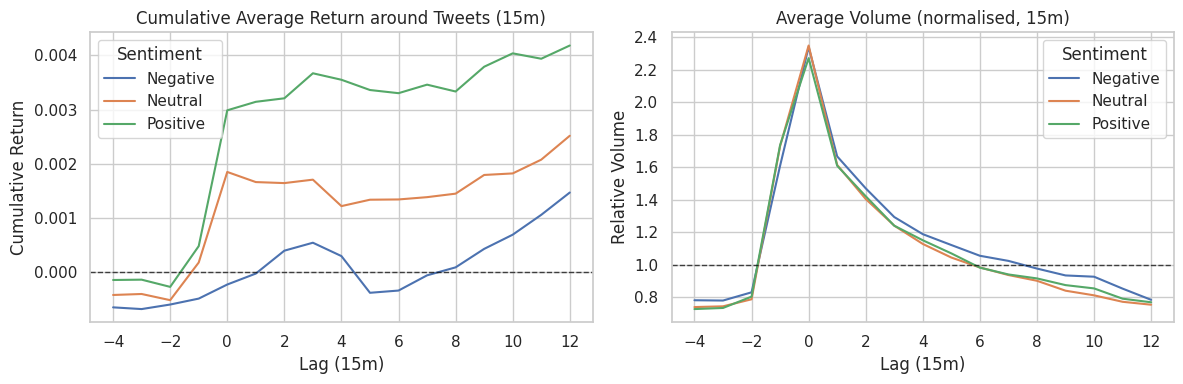

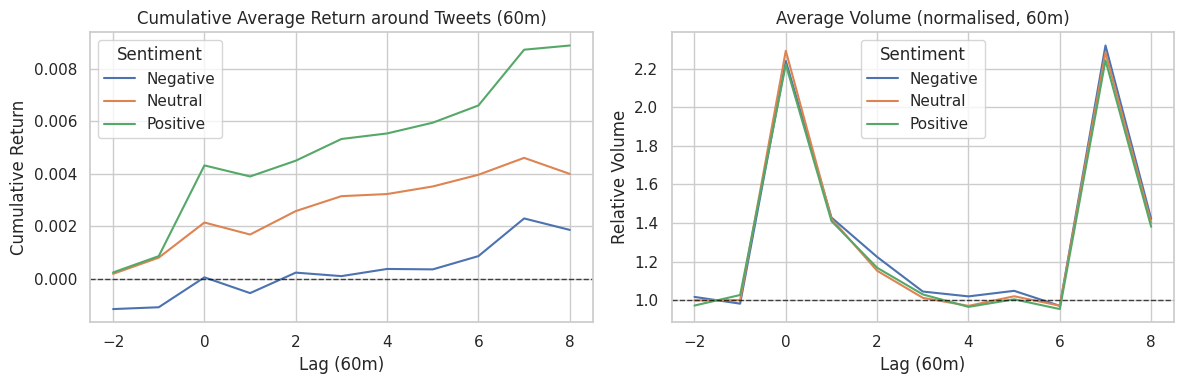

In [54]:
def plot_event_response(events: pd.DataFrame, freq_label: str = '15m') -> None:
    """
    Plot cumulative average returns (CAR) and normalised trading volume
    around tweet events for a given frequency.

    Parameters
    ----------
    events : pd.DataFrame
        Event-study dataset created by `build_event_windows_from_aligned`.
        Must include columns: 'Sentiment', 'Lag', 'Return', 'Volume'.
    freq_label : str, default='15m'
        Label for the x-axis (e.g. '15m', '60m') to indicate bar frequency.

    Returns
    -------
    None
        Displays two side-by-side plots:
        1. Cumulative average returns (CAR) by sentiment
        2. Average trading volume (normalised) by sentiment
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # --- Cumulative Average Returns (CAR) ---
    car = (
        events.groupby(['Sentiment', 'Lag'])['Return']
        .mean()
        .groupby(level=0).cumsum()
        .reset_index()
    )

    sns.lineplot(data=car, x='Lag', y='Return', hue='Sentiment', ax=ax[0])
    ax[0].axhline(0, linestyle='--', linewidth=1, color='black', alpha=0.7)
    ax[0].set_title(f'Cumulative Average Return around Tweets ({freq_label})')
    ax[0].set_xlabel(f'Lag ({freq_label})')
    ax[0].set_ylabel('Cumulative Return')

    # --- Normalised Volume ---
    vol = (
        events.groupby(['Sentiment', 'Lag'])['Volume']
        .mean()
        .reset_index()
    )

    # Normalise each sentiment by its pre-event average (lags < 0)
    for sentiment in vol['Sentiment'].unique():
        base = vol.loc[
            (vol['Sentiment'] == sentiment) & (vol['Lag'] < 0), 'Volume'
        ].mean()
        vol.loc[vol['Sentiment'] == sentiment, 'Volume'] /= (
            base if pd.notna(base) and base != 0 else 1.0
        )

    sns.lineplot(data=vol, x='Lag', y='Volume', hue='Sentiment', ax=ax[1])
    ax[1].axhline(1, linestyle='--', linewidth=1, color='black', alpha=0.7)
    ax[1].set_title(f'Average Volume (normalised, {freq_label})')
    ax[1].set_xlabel(f'Lag ({freq_label})')
    ax[1].set_ylabel('Relative Volume')

    plt.tight_layout()
    plt.show()


# Example usage
plot_event_response(events_15m, '15m')
plot_event_response(events_60m, '60m')

In [55]:
def car_summary(events: pd.DataFrame, horizons=[0, 4, 8, 12], freq_label: str = "15m") -> pd.DataFrame:
    """
    Compute summary statistics for Cumulative Average Returns (CAR)
    at specified horizons for each sentiment group.

    Parameters
    ----------
    events : pd.DataFrame
        Event study data with columns: 'TweetTime', 'Lag', 'Return', 'Sentiment'.
    horizons : list of int, default=[0, 4, 8, 12]
        Lags (in bars) at which to report CAR values.
    freq_label : str, default="15m"
        Label to indicate bar frequency (e.g., '15m', '60m').

    Returns
    -------
    pd.DataFrame
        A summary table with:
        - Sentiment group
        - Horizon (lag)
        - Number of tweets (N)
        - Mean CAR
        - t-statistic (one-sample t-test against 0)
        - p-value
    """
    rows = []

    # Loop through each sentiment group
    for sentiment, group in events.groupby("Sentiment"):
        # Pivot to get returns aligned by lag for each tweet, then accumulate over time
        pivot = (
            group.pivot_table(index="TweetTime", columns="Lag", values="Return")
            .cumsum(axis=1)
        )

        # Extract stats for each requested horizon
        for h in horizons:
            if h in pivot.columns:
                vals = pivot[h].dropna()
                mean_val = vals.mean()
                t_stat, p_val = stats.ttest_1samp(vals, 0.0, nan_policy="omit")

                rows.append({
                    "Sentiment": sentiment,
                    "Horizon": f"Lag {h} ({freq_label})",
                    "N tweets": len(vals),
                    "Mean CAR": mean_val,
                    "t-stat": t_stat,
                    "p-value": p_val
                })

    return pd.DataFrame(rows)


# --- Example usage ---
# 15-minute horizons (up to +3h)
car_table_15m = car_summary(events_15m, horizons=[0, 4, 8, 12], freq_label="15m")

# 60-minute horizons (up to +8h)
car_table_60m = car_summary(events_60m, horizons=[0, 2, 4, 6, 8], freq_label="60m")

display(car_table_15m)
display(car_table_60m)



,Sentiment,Horizon,N tweets,Mean CAR,t-stat,p-value
0,Negative,Lag 0 (15m),499,-0.000131,-0.103520,0.917592
1,Negative,Lag 4 (15m),499,0.000395,0.272802,0.785119
2,Negative,Lag 8 (15m),499,0.000167,0.104365,0.916922
3,Negative,Lag 12 (15m),499,0.001519,0.886239,0.375916
4,Neutral,Lag 0 (15m),1460,0.001851,2.398663,0.016580
5,Neutral,Lag 4 (15m),1460,0.001221,1.377861,0.168457
6,Neutral,Lag 8 (15m),1460,0.001451,1.506339,0.132197
7,Neutral,Lag 12 (15m),1460,0.002519,2.493929,0.012744
8,Positive,Lag 0 (15m),1516,0.002988,4.005828,0.000065
9,Positive,Lag 4 (15m),1516,0.003551,3.981095,0.000072


,Sentiment,Horizon,N tweets,Mean CAR,t-stat,p-value
0,Negative,Lag 0 (60m),499,0.000161,0.105693,9.158684e-01
1,Negative,Lag 2 (60m),499,0.000251,0.146572,8.835294e-01
2,Negative,Lag 4 (60m),499,0.000448,0.224984,8.220841e-01
3,Negative,Lag 6 (60m),499,0.000934,0.436476,6.626804e-01
4,Negative,Lag 8 (60m),499,0.001847,0.685363,4.934336e-01
5,Neutral,Lag 0 (60m),1460,0.002142,2.465684,1.378954e-02
6,Neutral,Lag 2 (60m),1460,0.002577,2.541793,1.113126e-02
7,Neutral,Lag 4 (60m),1460,0.003227,2.893601,3.865086e-03
8,Neutral,Lag 6 (60m),1460,0.003962,3.305276,9.718593e-04
9,Neutral,Lag 8 (60m),1460,0.003994,2.766868,5.731217e-03


In [56]:
def car_summary_with_ci(events: pd.DataFrame, horizons=[0, 4, 8, 12], freq_label: str = "15m") -> pd.DataFrame:
    """
    Compute CAR (Cumulative Average Returns) summary with 95% confidence intervals
    at specified horizons for each sentiment group.

    Parameters
    ----------
    events : pd.DataFrame
        Event study data with columns: 'TweetTime', 'Lag', 'Return', 'Sentiment'.
    horizons : list of int, default=[0, 4, 8, 12]
        Lags (in bars) at which to report CAR values.
    freq_label : str, default="15m"
        Label to indicate bar frequency (e.g., '15m', '60m').

    Returns
    -------
    pd.DataFrame
        A summary table with:
        - Sentiment group
        - Horizon (lag + freq)
        - Number of tweets (N)
        - Mean CAR
        - 95% confidence interval (as string)
        - t-statistic
        - p-value
    """
    rows = []

    # Loop over sentiment groups
    for sentiment, group in events.groupby("Sentiment"):
        # Build CAR trajectory per tweet (cumulative sum of returns by lag)
        pivot = (
            group.pivot_table(index="TweetTime", columns="Lag", values="Return")
            .cumsum(axis=1)
        )

        # Collect stats at each requested horizon
        for h in horizons:
            if h in pivot.columns:
                vals = pivot[h].dropna()
                if len(vals) == 0:
                    continue

                mean_val = vals.mean()
                se = vals.std(ddof=1) / np.sqrt(len(vals))  # standard error
                ci_low, ci_high = mean_val - 1.96 * se, mean_val + 1.96 * se
                t_stat, p_val = stats.ttest_1samp(vals, 0.0, nan_policy="omit")

                rows.append({
                    "Sentiment": sentiment,
                    "Horizon": f"Lag {h} ({freq_label})",
                    "N tweets": len(vals),
                    "Mean CAR": mean_val,
                    "95% CI": f"[{ci_low:.4f}, {ci_high:.4f}]",
                    "t-stat": t_stat,
                    "p-value": p_val
                })

    return pd.DataFrame(rows)


# --- Example usage ---
car_table_15m_ci = car_summary_with_ci(events_15m, horizons=[0, 4, 8, 12], freq_label="15m")
car_table_60m_ci = car_summary_with_ci(events_60m, horizons=[0, 2, 4, 6, 8], freq_label="60m")

display(car_table_15m_ci)
display(car_table_60m_ci)

,Sentiment,Horizon,N tweets,Mean CAR,95% CI,t-stat,p-value
0,Negative,Lag 0 (15m),499,-0.000131,"[-0.0026, 0.0023]",-0.103520,0.917592
1,Negative,Lag 4 (15m),499,0.000395,"[-0.0024, 0.0032]",0.272802,0.785119
2,Negative,Lag 8 (15m),499,0.000167,"[-0.0030, 0.0033]",0.104365,0.916922
3,Negative,Lag 12 (15m),499,0.001519,"[-0.0018, 0.0049]",0.886239,0.375916
4,Neutral,Lag 0 (15m),1460,0.001851,"[0.0003, 0.0034]",2.398663,0.016580
5,Neutral,Lag 4 (15m),1460,0.001221,"[-0.0005, 0.0030]",1.377861,0.168457
6,Neutral,Lag 8 (15m),1460,0.001451,"[-0.0004, 0.0033]",1.506339,0.132197
7,Neutral,Lag 12 (15m),1460,0.002519,"[0.0005, 0.0045]",2.493929,0.012744
8,Positive,Lag 0 (15m),1516,0.002988,"[0.0015, 0.0044]",4.005828,0.000065
9,Positive,Lag 4 (15m),1516,0.003551,"[0.0018, 0.0053]",3.981095,0.000072


,Sentiment,Horizon,N tweets,Mean CAR,95% CI,t-stat,p-value
0,Negative,Lag 0 (60m),499,0.000161,"[-0.0028, 0.0031]",0.105693,9.158684e-01
1,Negative,Lag 2 (60m),499,0.000251,"[-0.0031, 0.0036]",0.146572,8.835294e-01
2,Negative,Lag 4 (60m),499,0.000448,"[-0.0035, 0.0044]",0.224984,8.220841e-01
3,Negative,Lag 6 (60m),499,0.000934,"[-0.0033, 0.0051]",0.436476,6.626804e-01
4,Negative,Lag 8 (60m),499,0.001847,"[-0.0034, 0.0071]",0.685363,4.934336e-01
5,Neutral,Lag 0 (60m),1460,0.002142,"[0.0004, 0.0038]",2.465684,1.378954e-02
6,Neutral,Lag 2 (60m),1460,0.002577,"[0.0006, 0.0046]",2.541793,1.113126e-02
7,Neutral,Lag 4 (60m),1460,0.003227,"[0.0010, 0.0054]",2.893601,3.865086e-03
8,Neutral,Lag 6 (60m),1460,0.003962,"[0.0016, 0.0063]",3.305276,9.718593e-04
9,Neutral,Lag 8 (60m),1460,0.003994,"[0.0012, 0.0068]",2.766868,5.731217e-03
